In [49]:
!pip3 install pmdarima


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [50]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import re
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from collections import defaultdict
import ipaddress
import socket, struct
from hilbertcurve.hilbertcurve import HilbertCurve
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import entropy
from multiprocessing import Pool

sns.set()

In [51]:
# 1+1: Tue Aug 22 00:00:00 1995

data = {'Timestamp': [], 'Src IP': []}

# 178.47.232.191 22/Jan/2019:04:54:22 +0330 GET 400 166 - Yowai/2.0 -
f = 'zanbil/access.log'

regex = r'^(?<IP_ADDRESS>\d{3}.\d{3}.\d{3}).(?<DATE_TIME>20\d{2}-\d{2}-\d{2}:\d{2}:\d{2}+\d{3}).(?<REQUEST_TYPE>\w).(?<REQUEST_STATUS>\d{3}).(?<RESPONSE_SIZE>\d{3}).(?<USER_AGENT>\w).(?<REFERER>\w)'

for line in open(f):
    

    # Extract the IP address and timestamp from the log line
    ip_address, line = line.split(' ',1)
    # Define a regular expression to match the timestamp
    timestamp_regex = r"\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} [+|-]\d{4}"

    # Use the regular expression to search for the timestamp in the string
    match = re.search(timestamp_regex, line)

    if match:
        # If a match is found, print the timestamp
        timestamp = match.group()
    else:
        # If no match is found, print an error message
        print("No timestamp found in the string.")
        break


    
    data['Src IP'].append(ip_address)
    data['Timestamp'].append(timestamp)
df = pd.DataFrame(data)

In [52]:
format_str = "%d/%b/%Y:%H:%M:%S %z"
def preprocess_timeseries(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'],format=format_str)
    # Set the Timestamp column as the DataFrame index
    df.set_index('Timestamp', inplace=True)

preprocess_timeseries(df)

In [53]:
df.head()

,Src IP
Timestamp,
2019-01-22 03:56:14+03:30,54.36.149.41
2019-01-22 03:56:16+03:30,31.56.96.51
2019-01-22 03:56:16+03:30,31.56.96.51
2019-01-22 03:56:17+03:30,40.77.167.129
2019-01-22 03:56:17+03:30,91.99.72.15


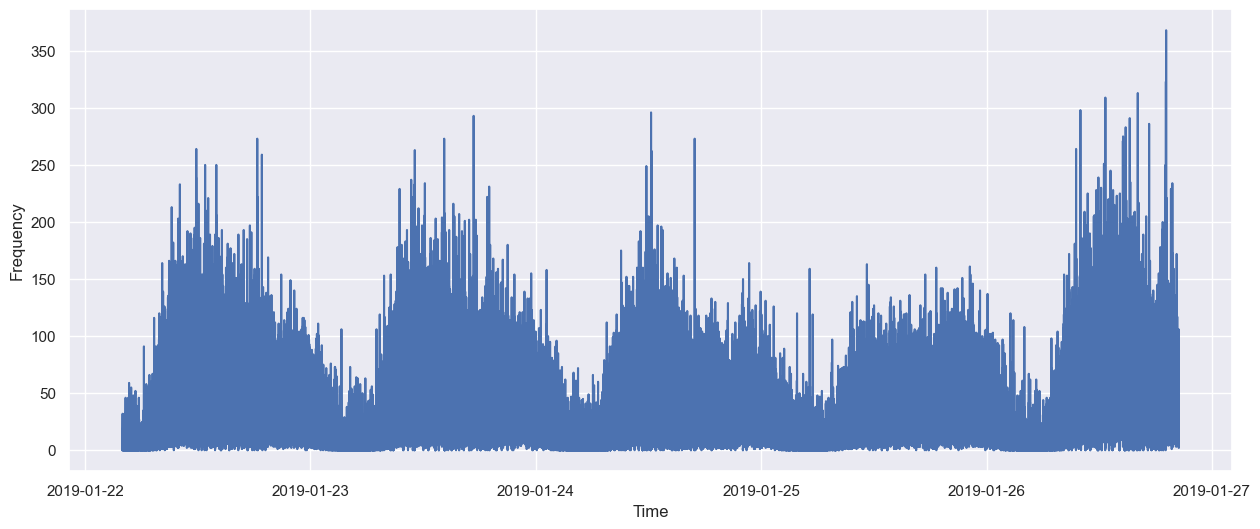

In [54]:
def plot_timeseries(df):
    # Resample the DataFrame to one-second intervals and count the number of occurrences
    resampled = df['Src IP'].resample('1S').count()

    # Plot the resampled data
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(resampled.index, resampled.values)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.show()

    return resampled

timeseries_df = plot_timeseries(df)

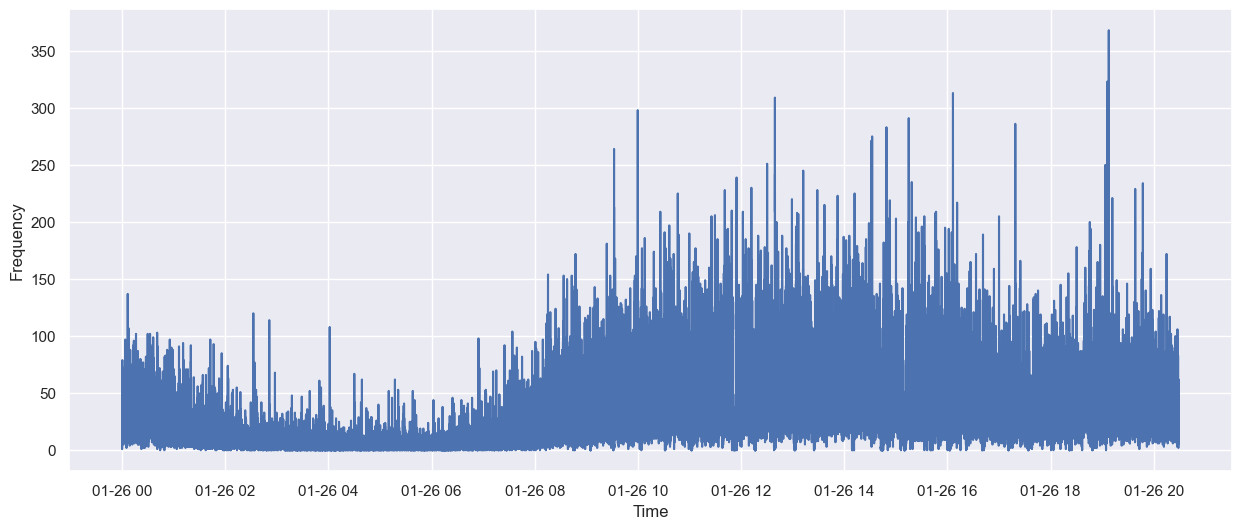

In [55]:
# Date with the maximum value
max_timestamp = timeseries_df.idxmax()
mask = df.index.date == max_timestamp.date()
filtered_df = df.loc[mask]

timeseries_df = plot_timeseries(filtered_df)

In [56]:
 model = auto_arima(timeseries_df, start_p=0, start_q=0, max_p=3, max_q=3, d=None,
                   seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore",
                   trace=True, scoring='mse')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=659995.948, Time=1.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=654166.063, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=648598.521, Time=8.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=659993.948, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=639910.215, Time=21.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=639850.585, Time=34.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=650428.246, Time=2.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=639732.725, Time=34.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=648121.090, Time=2.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=639853.504, Time=40.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=639912.632, Time=27.51 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=639730.808, Time=17.47 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=639848.585, Time=12.66 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=648119.090, Time=1.80 se

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                73754
Model:               SARIMAX(3, 1, 1)   Log Likelihood             -319860.404
Date:                Wed, 26 Apr 2023   AIC                         639730.808
Time:                        18:38:29   BIC                         639776.850
Sample:                    01-26-2019   HQIC                        639744.974
                         - 01-26-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.002    219.760      0.000       0.478       0.487
ar.L2          0.0152      0.003      5.235      0.000       0.010       0.021
ar.L3          0.0422      0.003     15.498      0.000       0.037       0.048
ma.L1         -0.9851      0.001  -1731.698      0.000      -0.986      -0.984
sigma2       342.0863      0.674    507.708      0.000     340.766     343.407
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):            518026.15
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               7.86   Skew:                             1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


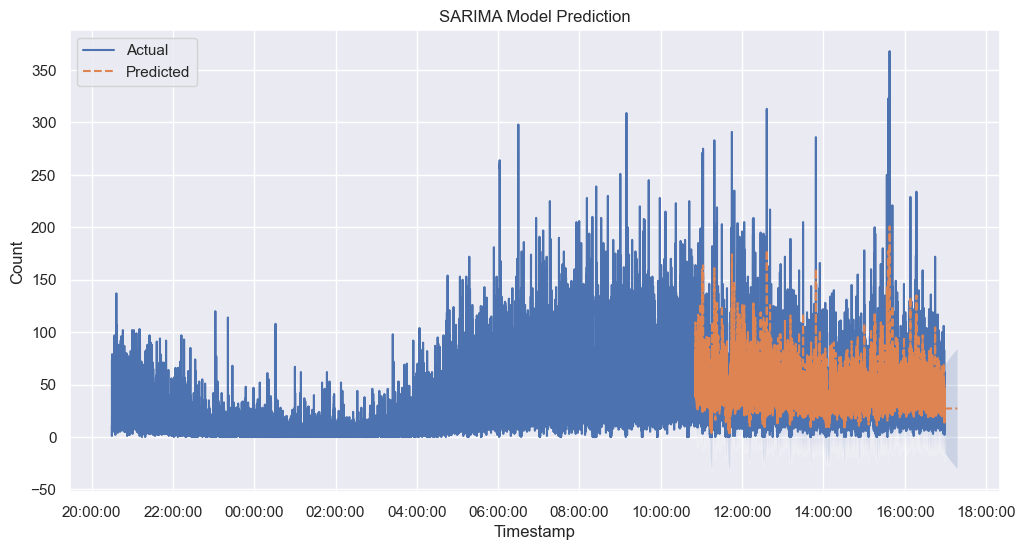

In [66]:


# create a SARIMA model with (p, d, q) = (1, 1, 1) and (P, D, Q, s) = (0, 1, 1, 60)
model = ARIMA(timeseries_df, order=(3,1,1))
results = model.fit()

# predict the values for the next 30%
threshold = int(len(timeseries_df) * .30)
pred = results.get_prediction(start=timeseries_df.index[-threshold], end=timeseries_df.index[-1] + pd.Timedelta(seconds=threshold/20), dynamic=False)

# extract the predicted values, the lower and upper confidence intervals
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# plot the actual values, the predicted values, and the error margins
fig, ax = plt.subplots(figsize=(12, 6))

# plot the actual values
ax.plot(timeseries_df.index, timeseries_df, label='Actual')

# plot the predicted values
ax.plot(pred_mean.index, pred_mean, label='Predicted', linestyle='--')

# plot the error margins
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], alpha=0.2)

# set the axis labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')
ax.set_title('SARIMA Model Prediction')


# Set the date ticks
date_fmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# show the legend
ax.legend()

plt.show()


In [59]:
def convert_ip_to_int2(ip):
    # Convert the IP address to an integer
    ip_int = int(ipaddress.IPv4Address(ip_str))

    # Convert each integer part of the IP address to a binary string and concatenate them
    ip_parts = (ip_int >> 24, (ip_int >> 16) & 255, (ip_int >> 8) & 255, ip_int & 255)
    binary_str = ''.join(format(p, '08b') for p in ip_parts)

    # Convert each integer part of the IP address to a binary string and concatenate them
    ip_parts = (ip_int >> 24, (ip_int >> 16) & 255, (ip_int >> 8) & 255, ip_int & 255)
    binary_str = ''.join(format(p, '08b') for p in ip_parts)

    # Convert the binary string to a 128-bit integer
    ip_int128 = int(binary_str, 2)
    return ip_int128

def convert_ip_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

def convert_ip_to_hc_coord(ips):
    ip_to_hc = defaultdict(list)
    hc_to_ip = defaultdict(list)
    
        
    set_ips = set(ips)
    
    map_ips = {}
    for i,ip in enumerate(set_ips):
        val = convert_ip_to_int(ip)
        map_ips[val] = i
    coords = []    
    n = 2
    bits = 64
    # Compute the Hilbert coordinate for the 128-bit integer
    hc = HilbertCurve(bits, n, n_procs=-1)
    coords_set = hc.points_from_distances(map_ips.keys())
    
    coords = []
    for ip in ips:
        int_ip = convert_ip_to_int(ip)
        index = map_ips[int_ip]
        coord = coords_set[index]
        coords.append(coord)
    return coords

coords = convert_ip_to_hc_coord(filtered_df['Src IP'])
filtered_df['Coords'] = coords

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/9l/7vfj4byj1msbc0qsc644jv_r0000gn/T/ipykernel_59632/1874796167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = labels


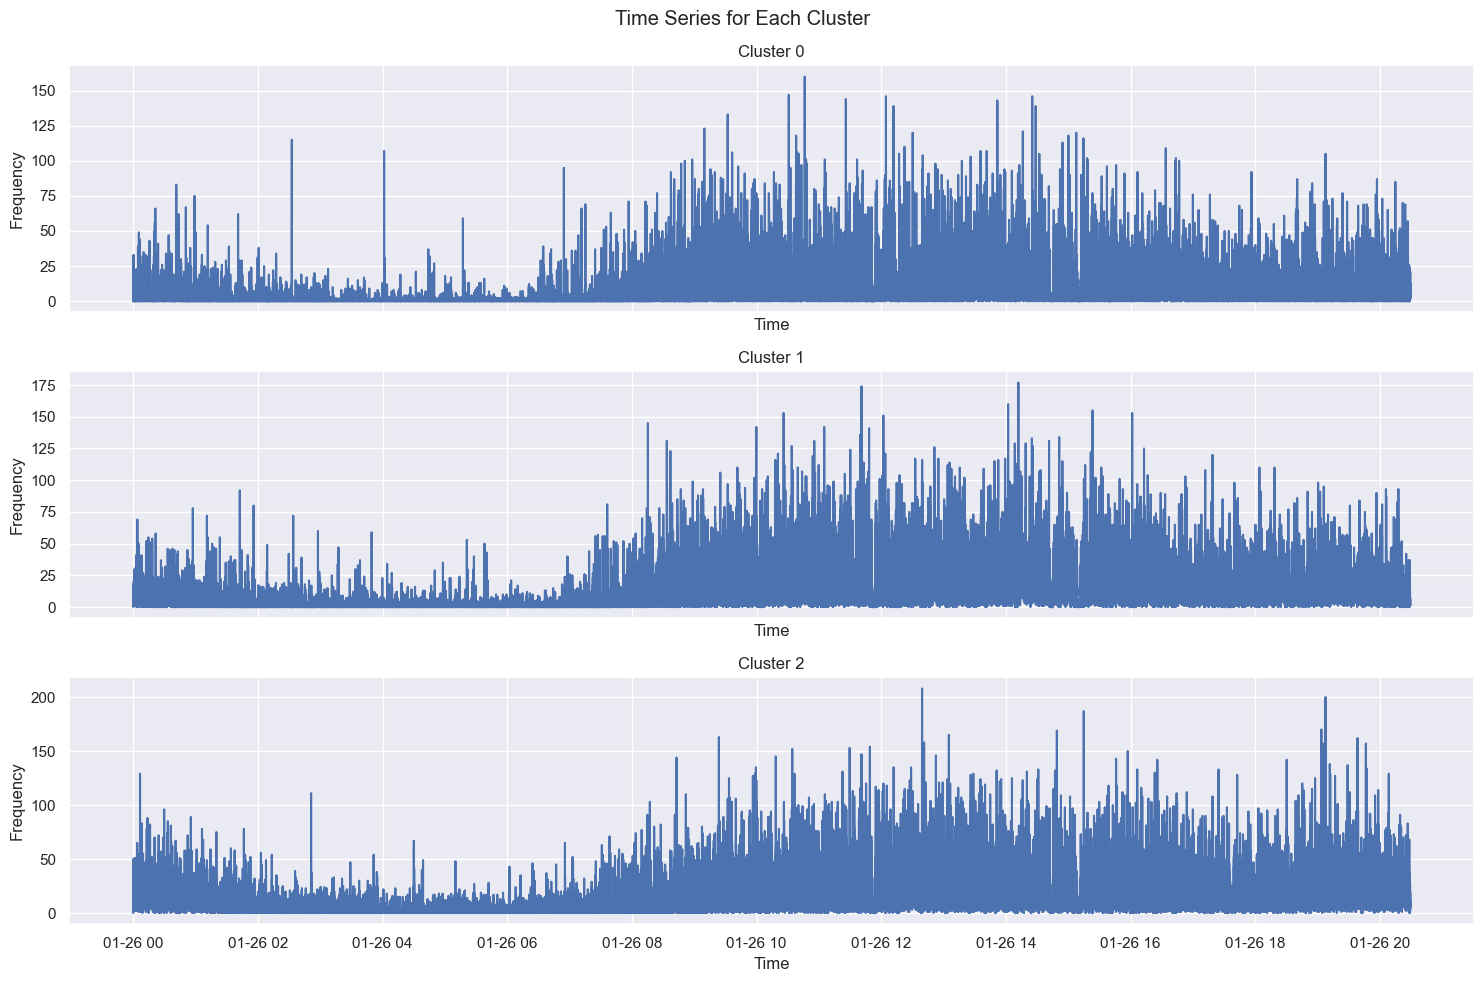

In [60]:
# cluster the coords array using K-Means
kmeans = KMeans(n_clusters=3, random_state=0).fit(coords)
labels = kmeans.labels_

# add the cluster labels as a new column to the original DataFrame
filtered_df['Cluster'] = labels


fig, axes = plt.subplots(nrows=len(np.unique(labels)), sharex=True, figsize=(15, 10))
# iterate over the clusters and plot the time series for each cluster
for i, label in enumerate(np.unique(labels)):
    # filter the DataFrame for the current cluster
    cluster_df = filtered_df[filtered_df['Cluster'] == label]
    
    # resample the DataFrame to one-second intervals and count the number of occurrences
    resampled = cluster_df['Src IP'].resample('1S').count()
    
    # plot the resampled data on the corresponding subplot
    ax = axes[i]
    ax.plot(resampled.index, resampled.values)
    ax.set_title(f'Cluster {label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# set the overall title of the figure
fig.suptitle('Time Series for Each Cluster')

# adjust the layout of the subplots to avoid overlapping
fig.tight_layout()

# show the plot
plt.show()

In [61]:
freq_table = filtered_df['Src IP'].value_counts()

In [62]:
freq_table[:10]

66.249.66.194      54049
66.249.66.91       44342
104.222.32.91      42053
91.99.47.57        38260
151.239.241.163    23907
23.101.169.3       13795
91.99.72.15         8974
66.249.66.92        8202
5.116.203.8         6948
207.46.13.49        6092
Name: Src IP, dtype: int64

In [63]:
top_ips = list(freq_table[:6].keys())
top_ips_dist = filtered_df[filtered_df['Src IP'].isin(top_ips)]

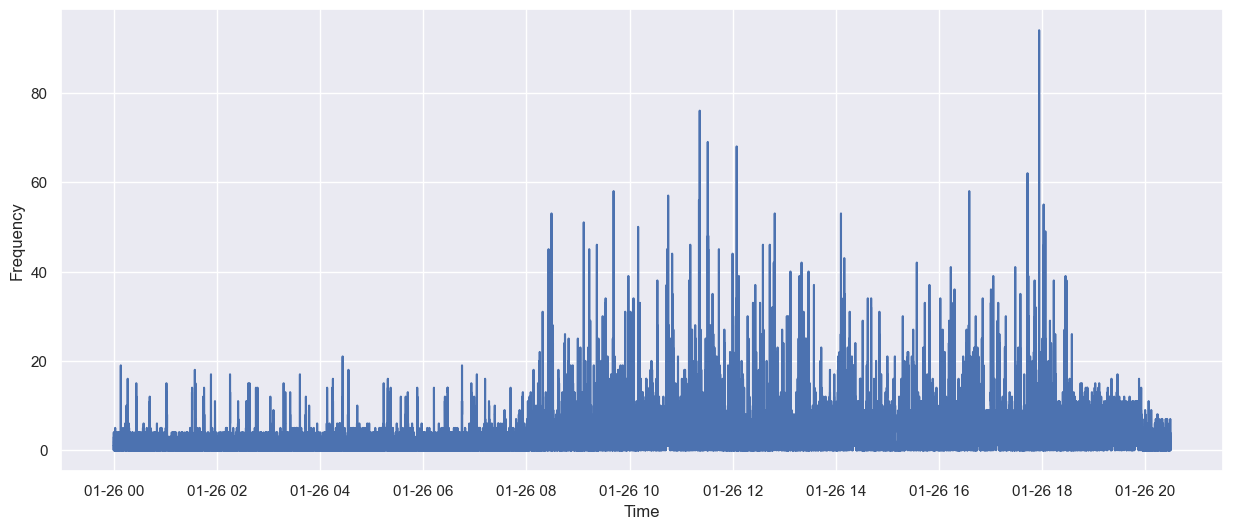

Timestamp
2019-01-26 00:00:00+03:30    1
2019-01-26 00:00:01+03:30    0
2019-01-26 00:00:02+03:30    0
2019-01-26 00:00:03+03:30    0
2019-01-26 00:00:04+03:30    0
                            ..
2019-01-26 20:29:08+03:30    0
2019-01-26 20:29:09+03:30    3
2019-01-26 20:29:10+03:30    1
2019-01-26 20:29:11+03:30    0
2019-01-26 20:29:12+03:30    1
Freq: S, Name: Src IP, Length: 73753, dtype: int64

In [64]:
plot_timeseries(top_ips_dist)

In [65]:
# # define a function to group the DataFrame by 'Src IP'
# def group_by_src_ip(df):
#     return df.groupby('Src IP')

# # define a function to compute entropy for each group
# def compute_entropy(group):
#     group = group.set_index('Timestamp').resample('1S').size()
#     return entropy(group)

# # create a Pool object with the number of processes
# num_processes = 4
# pool = Pool(num_processes)

# # group the DataFrame by 'Src IP' in parallel using the 'map()' method of the Pool object
# groups = pool.map(group_by_src_ip, [filtered_df]*num_processes)
# groups = [x[1] for x in groups]

# # compute the entropy for each group in parallel using the 'map()' method of the Pool object
# entropy_values = pool.map(compute_entropy, groups)

# # close the Pool object and wait for all processes to complete
# pool.close()
# pool.join()

# # create a new DataFrame object with the entropy values and the same index as the original DataFrame
# entropy_df = pd.DataFrame({'Entropy': entropy_values}, index=filtered_df.index.levels[1])

# # plot the entropy over time
# plt.plot(entropy_df.index, entropy_df['Entropy'])
# plt.xlabel('Timestamp')
# plt.ylabel('Entropy')
# plt.show()

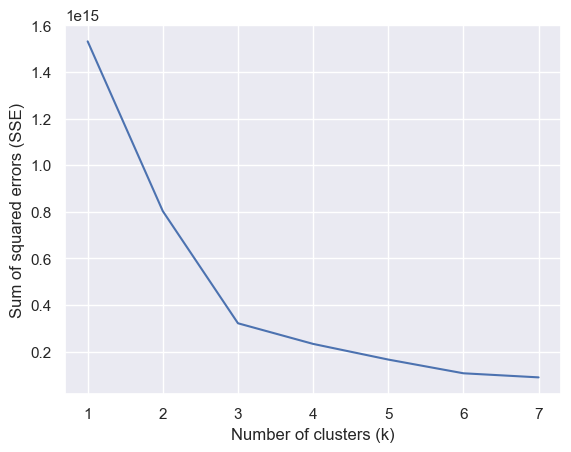

In [67]:

# create an empty list to store SSE values for each k value
sse = []
# try k values from 1 to 5
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
    kmeans.fit(coords)
    sse.append(kmeans.inertia_)

# plot SSE values for each k value
plt.plot(range(1, len(sse)+1), sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.show()



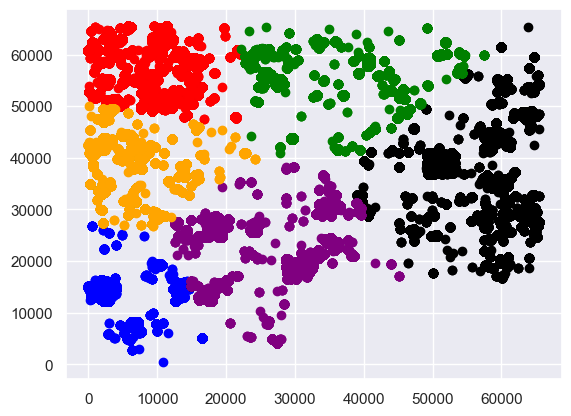

In [73]:
k = 6
kmeans = KMeans(n_clusters=k,n_init='auto',init='k-means++')
kmeans.fit(coords)
df2 = filtered_df.copy()
df2['Cluster'] = kmeans.labels_
# plot the scatter plot for the clusters
colors = ['blue','red','black','purple','green','orange']
for i in range(k):
    plt.scatter(df2[df2['Cluster']==i]['Coords'].apply(lambda x: x[0]), 
                df2[df2['Cluster']==i]['Coords'].apply(lambda x: x[1]), 
                color=colors[i])

In [74]:
import math
from collections import Counter
# Define a function to calculate entropy
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

# Calculate entropy of IP address for each cluster
for i in range(k):
    cluster_i = df2[df2['Cluster'] == i]['Src IP']
    vc = pd.Series(cluster_i).value_counts(normalize=True, sort=False)
    base = np.e
    entropy = -(vc * np.log(vc)/np.log(base)).sum()
#     ip_entropy = entropy(cluster_i['Src IP'])
    print(f"Entropy of IP address for Cluster {i}: {entropy}")

Entropy of IP address for Cluster 0: 8.812049540238698
Entropy of IP address for Cluster 1: 7.455408459292085
Entropy of IP address for Cluster 2: 7.355746865809433
Entropy of IP address for Cluster 3: 7.290635587219284
Entropy of IP address for Cluster 4: 5.480851320396132
Entropy of IP address for Cluster 5: 4.428198015214777


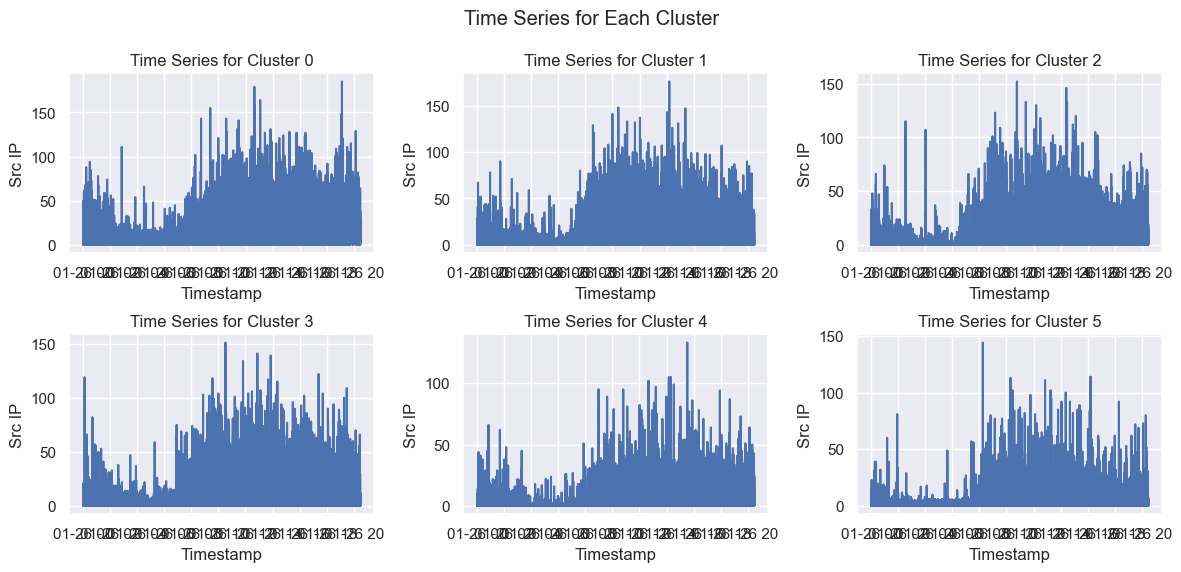

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dimensions of the grid
nrows = 3
ncols = 3

# Create the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))

# Flatten the axs array
axs = axs.flatten()

# Plot the time series for each cluster in a subplot
for i in range(k):
    cluster_i = df2[df2['Cluster'] == i]
    cluster_i_ts = cluster_i['Src IP'].resample('1S').count()
    sns.lineplot(data=cluster_i_ts, ax=axs[i])
    axs[i].set_title(f'Time Series for Cluster {i}')

# Remove the remaining subplots from the grid
for i in range(k, nrows*ncols):
    fig.delaxes(axs[i])

# Adjust the layout and spacing of the subplots
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Time Series for Each Cluster')
plt.show()


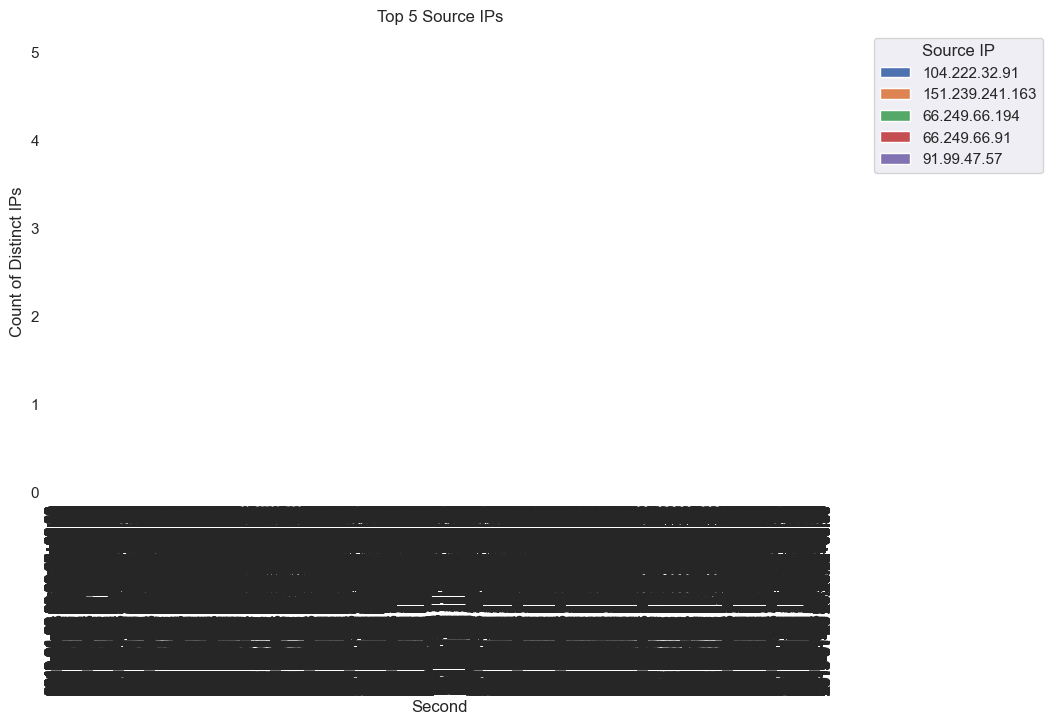

In [76]:
# Get the top 5 source IP addresses
freq_table = filtered_df['Src IP'].value_counts()
top_ips = list(freq_table[:5].keys())

# Filter the data to include only the top 5 IP addresses
top_df = filtered_df[filtered_df['Src IP'].isin(top_ips)]

# Group the data by second and source IP, and count the number of unique IP addresses
grouped_df = top_df.groupby([pd.Grouper(freq='1s'), 'Src IP'])['Src IP'].nunique()

# Convert the grouped data to a pivot table with source IP addresses as columns and seconds as the index
pivot_table = grouped_df.unstack(level='Src IP')


# Plot a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), ylabel='Count of Distinct IPs', xlabel='Second', title='Top 5 Source IPs')
plt.legend(title='Source IP', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

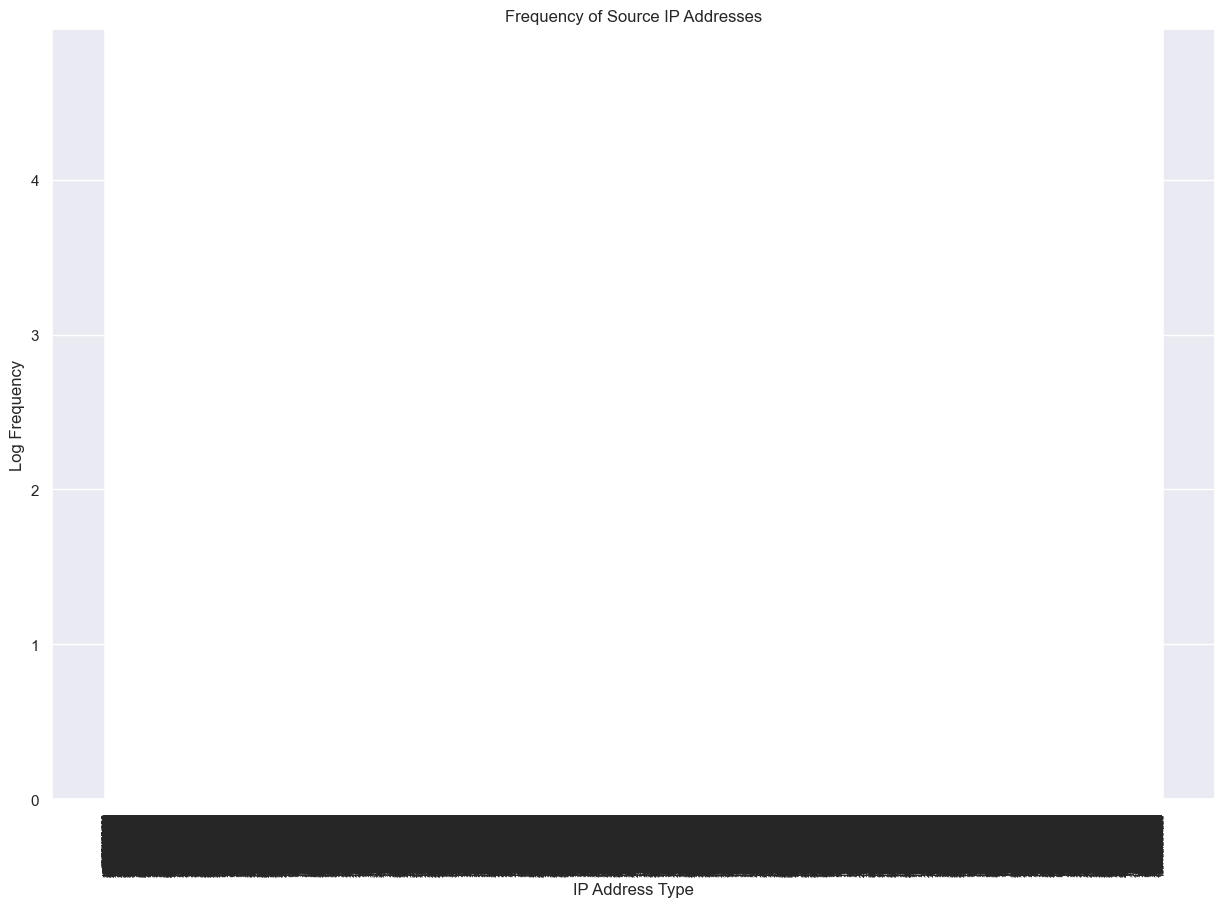

In [77]:

# compute IP address frequency counts
ip_counts = df['Src IP'].value_counts()

fig = plt.figure(figsize=(15, 10))
plt.bar(ip_counts.index, np.log10(ip_counts.values), width=0.5)
plt.xticks(np.arange(len(ip_counts.index)), ip_counts.index, rotation=90, fontsize=6)
plt.xlabel('IP Address Type')
plt.ylabel('Log Frequency')
plt.title('Frequency of Source IP Addresses')
plt.show()